# Model Analysis and Improvements

## Sections:
1. Data Loading and Preprocessing
2. Visualization of data
3. Model Training, Evaluation and Visualization
4. Algorithms Comparison 

In [89]:
# Importing essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

## Load and Prepare Data
Loading the Iris dataset, splitting it into features and target, and examining the dataset for any imbalances or missing values.

To improve the model's generalization ability, we removed 'Id' to allow the model to focus on biologically relevant data.

In [90]:
def load_data(file_path):  # Returns:   DataFrame: Loaded data.
    try:
        data = pd.read_csv(file_path)
        print("Data loaded successfully.")

        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None
    

def preprocess_data(data, target_column):
    try:
        # Separate features and target variable
        X = data.drop(columns=[target_column])
        y = data[target_column]
        
        # Split into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        print("Data preprocessing complete.")
        return X_train, X_test, y_train, y_test
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return None, None, None, None


### Scaling

We used StandardScaler to scale features in a dataset, specifically for preparing data for machine learning algorithms like K-Nearest Neighbors (KNN) and Support Vector Machines (SVM).

StandardScaler: This is a preprocessing tool from the sklearn.preprocessing module that standardizes the features by removing the mean and scaling to unit variance. The **formula** it uses is:

𝑧 = ( 𝑥 − 𝜇 ) / 𝜎 

where μ is the mean of the feature values and σ is the standard deviation.

When you call scaler.fit_transform(X_train), the StandardScaler computes the mean and standard deviation for each feature in the training dataset (X_train). This means that it analyzes the distribution of each feature in X_train and calculates these statistics.

After calculations, fit_transform standardizes the training data by applying the **formula**. As a result, X_train_scaled is a new dataset where each feature has a mean of 0 and a standard deviation of 1. This transformation ensures that the training data is centered around zero and scaled appropriately.

scaler.transform(X_test) uses the mean and standard deviation calculated from the TRAINING data to standardize the test dataset. This ensures that the test data is transformed in the same way as the training data, maintaining consistency. The resulting X_test_scaled will also have features centered around the same mean and scaled by the same standard deviation as the training data.

In another word, StandardScaler is creating a *consistent* new dataset for both the training and test sets based on the original data, specifically using the mean and standard deviation calculated from the training set.

However, scaled dataset is not typically required for Random Forests. Because it is an ensemble of decision trees, which are inherently insensitive to the scale of the features. Decision trees split the data based on thresholds of feature values, meaning that the absolute values of the features do not affect how the trees are constructed. 

Additionally, scaling can sometimes make it more difficult to interpret the feature importances from tree-based models because the importance scores are based on the original feature values. If the features have been scaled, the original context might be lost.

In [91]:
# Load dataset
data = load_data("Iris.csv")  # Adjust path as needed
data.drop("Id", axis="columns", inplace=True)
X_train, X_test, y_train, y_test = preprocess_data(data, "Species")

# Scaling features for KNN and SVM to standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Quick data check
print(data.head())
print(data["Species"].value_counts())  # Checking class balance

Data loaded successfully.
Data preprocessing complete.
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0            5.1           3.5            1.4           0.2  Iris-setosa
1            4.9           3.0            1.4           0.2  Iris-setosa
2            4.7           3.2            1.3           0.2  Iris-setosa
3            4.6           3.1            1.5           0.2  Iris-setosa
4            5.0           3.6            1.4           0.2  Iris-setosa
Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


## Data Visualization
Creating scatter plots and pair plots to visualize relationships among features and identify feature separations between species.

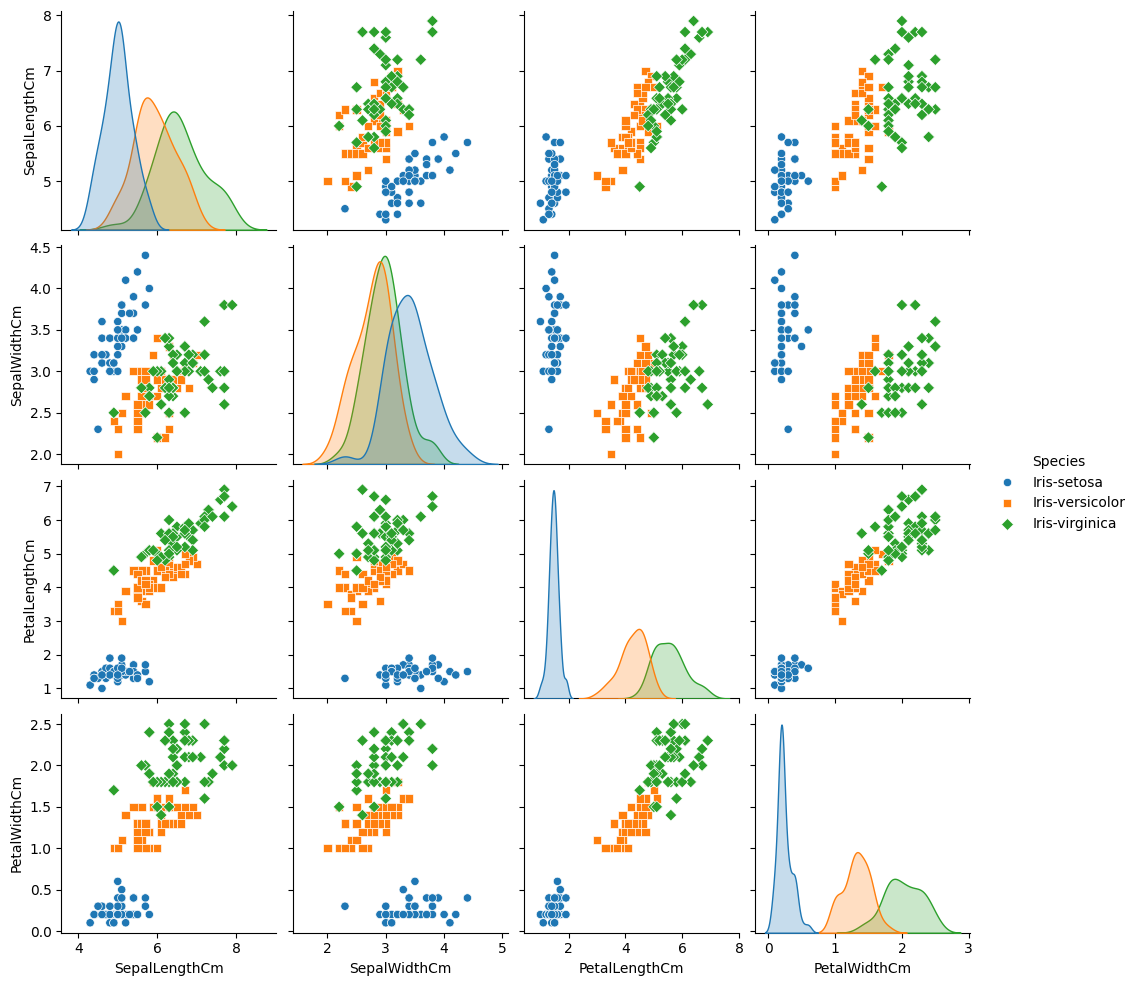

In [98]:
# Pair plot to visualize feature relationships by species
sns.pairplot(data, hue="Species", markers=["o", "s", "D"])
plt.show()


# # Scatter plot for specific feature pairs
# plt.figure(figsize=(12, 6))
# sns.scatterplot(x="SepalLengthCm", y="SepalWidthCm", hue="Species", data=data, s=100)
# plt.title("Sepal Length vs Sepal Width by Species")
# plt.show()

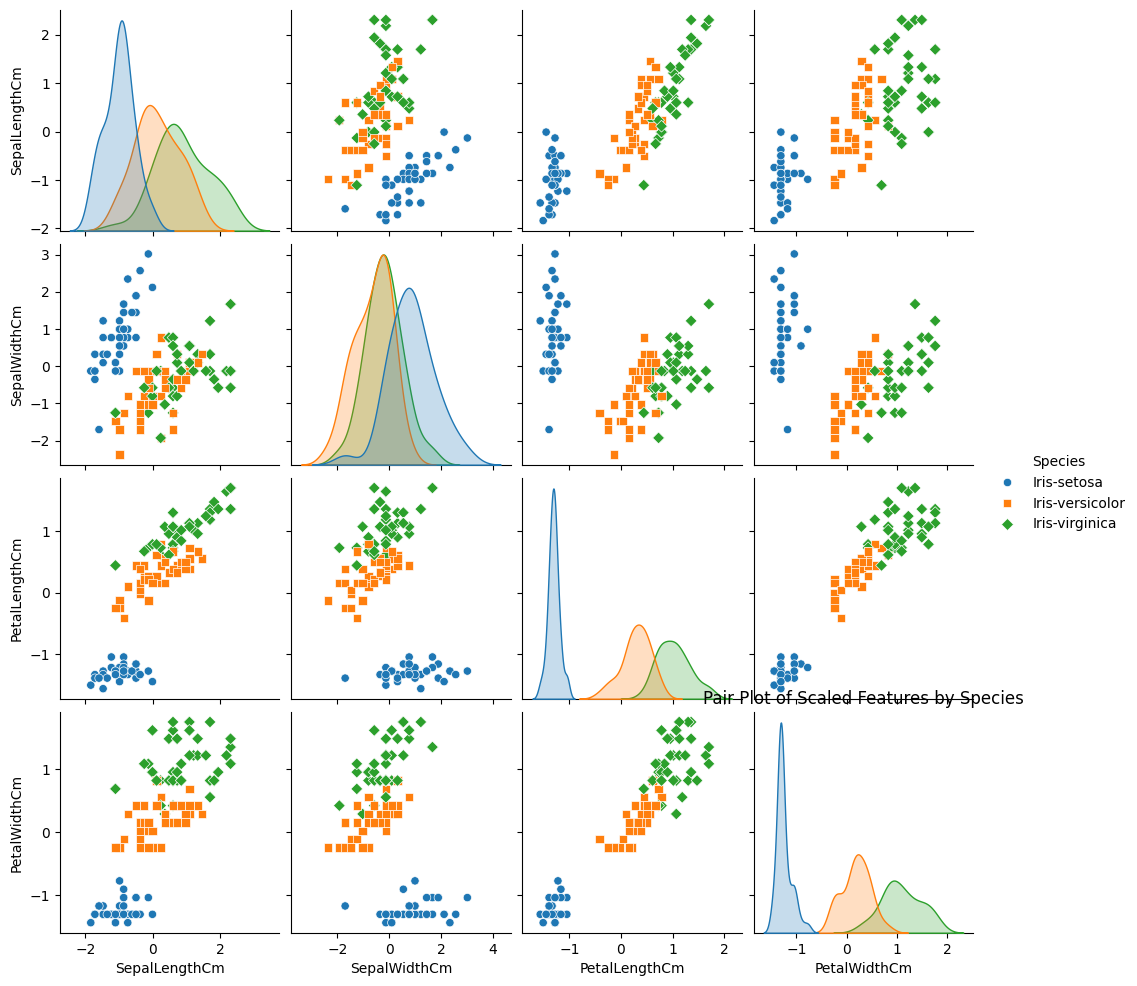

In [99]:
# Convert scaled data back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=data.drop(columns=["Species"]).columns)
X_train_scaled_df['Species'] = y_train.reset_index(drop=True)

# Pair plot to visualize feature relationships by species (scaled)
sns.pairplot(X_train_scaled_df, hue="Species", markers=["o", "s", "D"])
plt.title(label="Pair Plot of Scaled Features by Species",loc='center')
plt.show()

## Model Training, Evaluation and Vizualization

**Accuracy** is the ratio of correctly predicted instances to the total instances. (be misleading for imbalanced datasets)
Formula: Accuracy= (TP+TN)/(TP+TN+FP+FN)

**Precision** is the ratio of correctly predicted positive observations to the total predicted positives. (crucial in scenarios where false positives are costly)
Formula: Precision= TP/(TP+FP)

**Recall** (also known as Sensitivity or True Positive Rate) is the ratio of correctly predicted positive observations to the all relevant cases. (good at capturing relations) (important in medical diagnoses or fraud detection)
Formula: Recall= TP/(TP+FN)

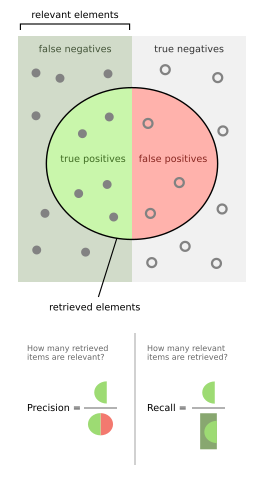


**The ROC (Receiver Operating Characteristic) curve** is a plot that shows the performance of a classifier across all classification thresholds.
*True Positive Rate (TPR):*Recall
*False Positive Rate (FPR):* The proportion of negatives incorrectly classified as positive.
Formula: FPR = FP/(FP+TN)
The ROC curve plots TPR against FPR at various threshold levels.

**The AUC (Area Under the Curve)** represents the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance


In [104]:
# Evaluation function
def evaluate_model(name, y_test, predictions, model=None):
    cm = confusion_matrix(y_test, predictions)
    species_names = data["Species"].unique()
    """
    Calculate TN for each class
    tn_class_1 = cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]  # TN for Setosa
    tn_class_2 = cm[0, 0] + cm[0, 2] + cm[2, 0] + cm[2, 2]  # TN for Versicolor
    tn_class_3 = cm[0, 0] + cm[0, 1] + cm[1, 0] + cm[1, 1]  # TN for Virginica
    
    TP = cm[0, 0] + cm[1, 1] + cm[2, 2]
    FP = (cm[:, 0].sum() + cm[:, 1].sum() + cm[:, 2].sum()) - TP
    FN = (cm[0, :].sum() + cm[1, :].sum() + cm[2, :].sum()) - TP
    TN = cm.sum() - (TP + FP + FN)
    
    print("Confusion Matrix:\n", cm)
    """

    def plot_confusion_matrix_with_explanations(y_test, name, cm):
        # Confusion matrix calculation
        explanation_matrix = np.empty_like(cm, dtype=object)
        total_TP, total_TN, total_FP, total_FN = 0, 0, 0, 0

        # Populate TP, FP, FN, and TN for each cell
        for i in range(len(species_names)):
            for j in range(len(species_names)):
                if i == j:
                    TP = cm[i, j]
                    FP = cm[:, j].sum() - TP  # for class i (sum of column minus TP)
                    FN = cm[i, :].sum() - TP  # for class i (sum of row minus TP)
                    TN = cm.sum() - (TP + FP + FN)
                    explanation_matrix[i, j] = (
                        f"TP: {TP} {species_names[i]}\ncorrectly predicted\n\n"
                        f"TN: {TN} not predicted as\n{species_names[i]})"
                    )
                    total_TP += TP
                    total_TN += TN
                else:
                    # False Positive for class j, False Negative for class i
                    FP = cm[:, j].sum() - cm[j, j]
                    FN = cm[i, :].sum() - cm[i, i]
                    explanation_matrix[i, j] = (
                        f"FP: {cm[i, j]} incorrectly predicted\nas {species_names[j]}\n\n"
                        f"FN: {cm[i, j]} missed prediction of \n{species_names[i]}"
                    )
                    total_FN += FN
                    total_FP += FP

        # Plotting the confusion matrix with explanations
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=explanation_matrix,
            fmt="",
            cmap="Reds",
            cbar=False,
            xticklabels=species_names,
            yticklabels=species_names,
            color="black",
        )

        plt.title(f"{name} Algorithm - Confusion Matrix with Explanations")
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        accuracy = (total_TP + total_TN) / (total_TP + total_TN + total_FP + total_FN)
        precision = total_TP / (total_TP + total_FP)
        recall = total_TP / (total_TP + total_FN)
        # accuracy = accuracy_score(y_test, predictions)
        # precision = precision_score(y_test, predictions, average="weighted")
        # recall = recall_score(y_test, predictions, average="weighted")
        auc = (
            roc_auc_score(y_test, model.predict_proba(X_test_scaled), multi_class="ovr")
            if model
            else "N/A"
        )

        print(
            f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, AUC: {auc}"
        )
        plt.show()
    plot_confusion_matrix_with_explanations(y_test, name, cm)

### Random Forest Model Training

Before trying different algorithms on the same task, We tested various parameters for the same algorithm to see if tuning would improve its performance and evaluated them on the test data.

From the feature importance comparison, **Petal Length** and **Petal Width** remain the most significant features in both models. The *default* model slightly emphasizes Petal Width, while the *tuned* model slightly favors Petal Length, suggesting a subtle shift in focus due to parameter changes. *Sepal Length and Sepal Width contribute minimally in both cases, which indicates that these features are less relevant to the model's decision-making.*

Tuned Model looks better...

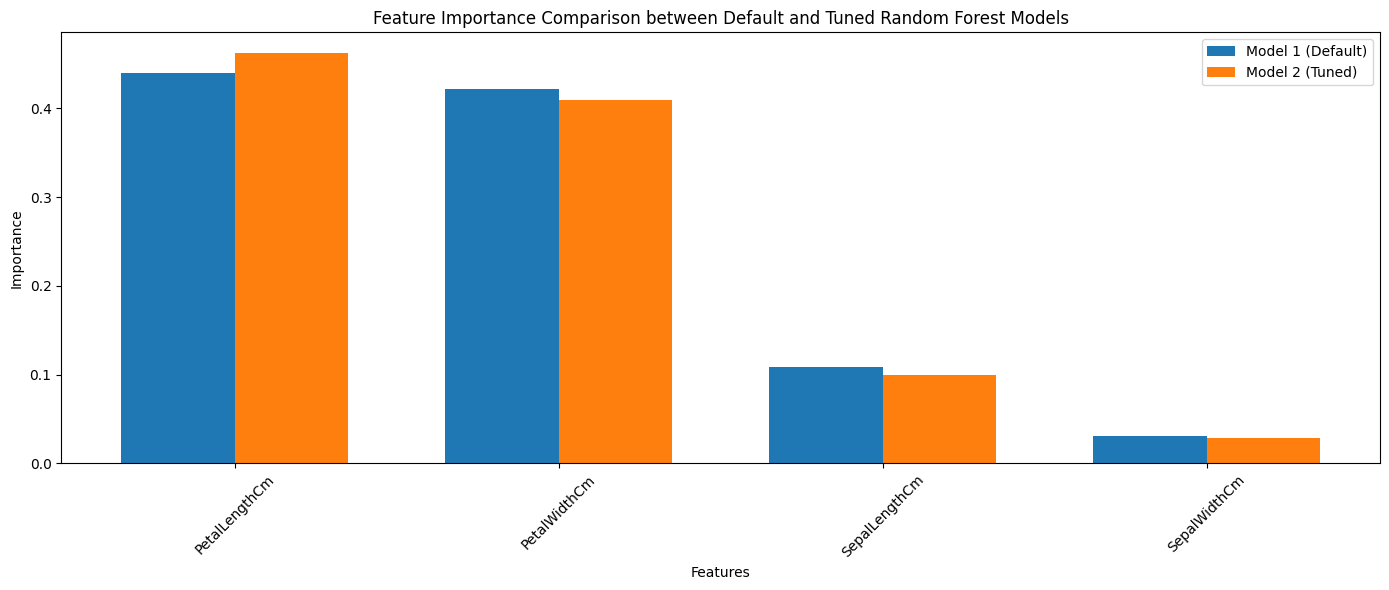

Random Forest 1 (Default) - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, AUC: N/A


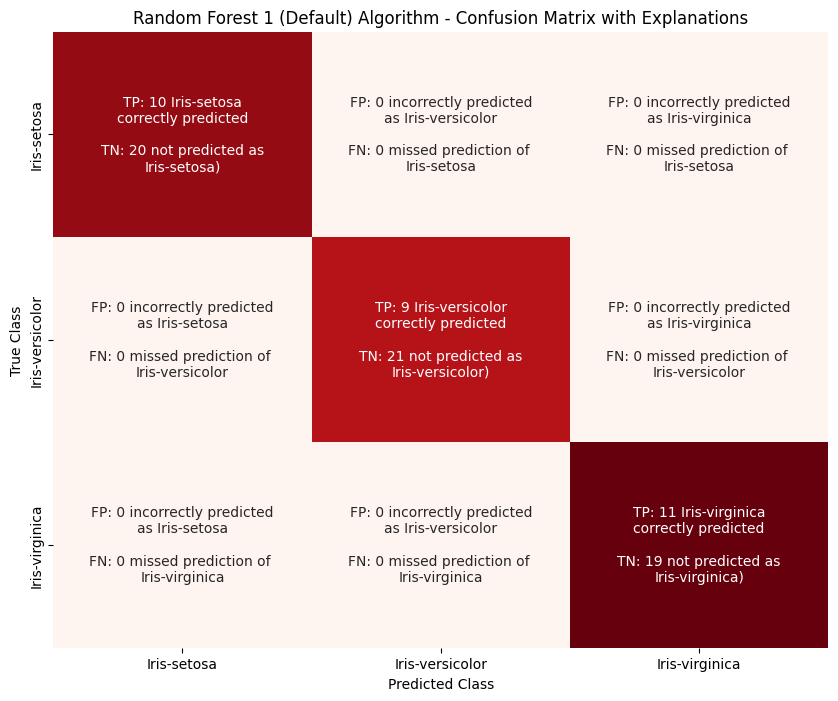

Random Forest 2 (Tuned) - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, AUC: N/A


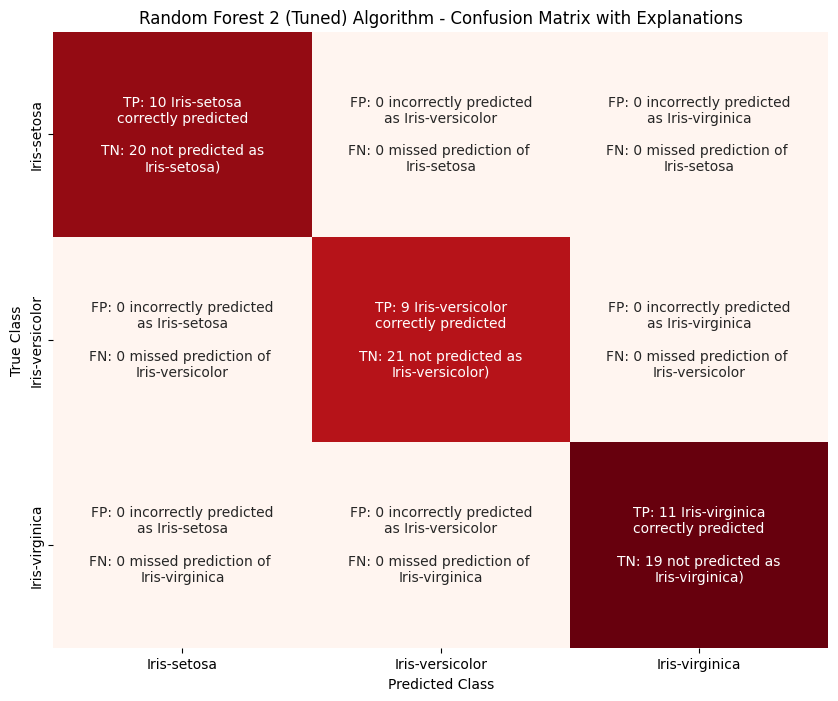

In [105]:
# Model 1: Default hyperparameters
rf_model_1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_1.fit(X_train, y_train)
rf_pred_1 = rf_model_1.predict(X_test)

# Model 2: Tuned hyperparameters
rf_model_2 = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42)
rf_model_2.fit(X_train, y_train)
rf_pred_2 = rf_model_2.predict(X_test)

# Extract feature importances for both models
importances_1 = rf_model_1.feature_importances_
importances_2 = rf_model_2.feature_importances_
features = data.drop(columns=["Species"]).columns

# Sorting features by importance for better visualization
indices_1 = np.argsort(importances_1)[::-1]
indices_2 = np.argsort(importances_2)[::-1]

plt.figure(figsize=(14, 6))

bar_width = 0.35  # Bar width for side-by-side bars
index = np.arange(len(features))

# Bar chart for Model 1
plt.bar(index, importances_1[indices_1], bar_width, label="Model 1 (Default)")
# Bar chart for Model 2
plt.bar(index + bar_width, importances_2[indices_2], bar_width, label="Model 2 (Tuned)")

# Adding labels and title
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance Comparison between Default and Tuned Random Forest Models")
plt.xticks(index + bar_width / 2, features[indices_1], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

evaluate_model("Random Forest 1 (Default)", y_test, rf_pred_1)
evaluate_model("Random Forest 2 (Tuned)", y_test, rf_pred_2)

### K-Nearest Neighbors Model Training, Evaluation and Vizualization
Training, Evaluation and Vizualization the KNN model using scaled data for optimal performance.

KNN - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, AUC: 1.0


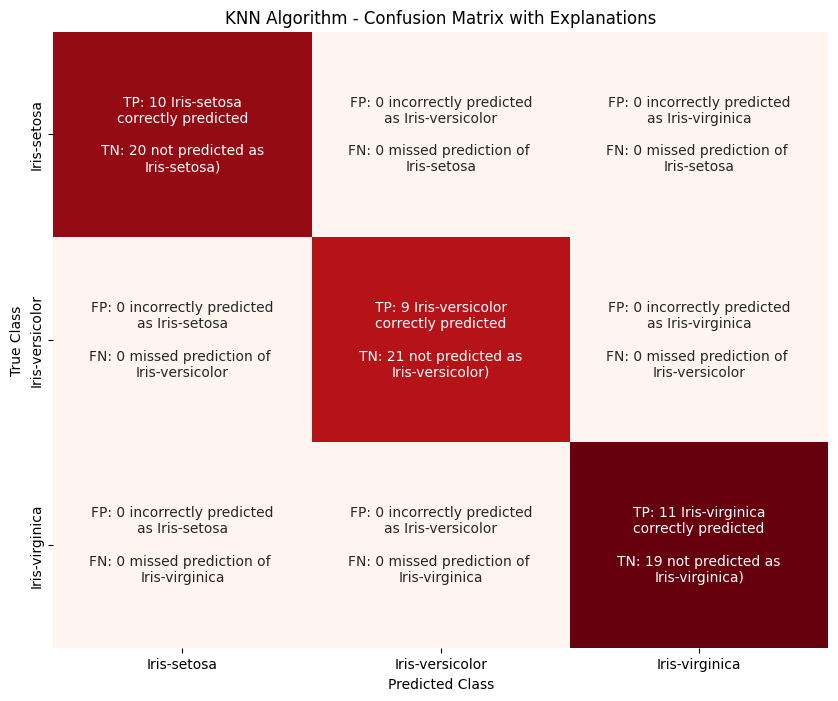

In [106]:
# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)

# Evaluation
evaluate_model("KNN", y_test, knn_pred, knn_model)

### Support Vector Machine Model Training, Evaluation and Vizualization
Training, the SVM model with a linear kernel and evaluating and Vizualizating its performance using scaled data.

SVM - Accuracy: 0.96, Precision: 0.94, Recall: 0.94, AUC: 1.0


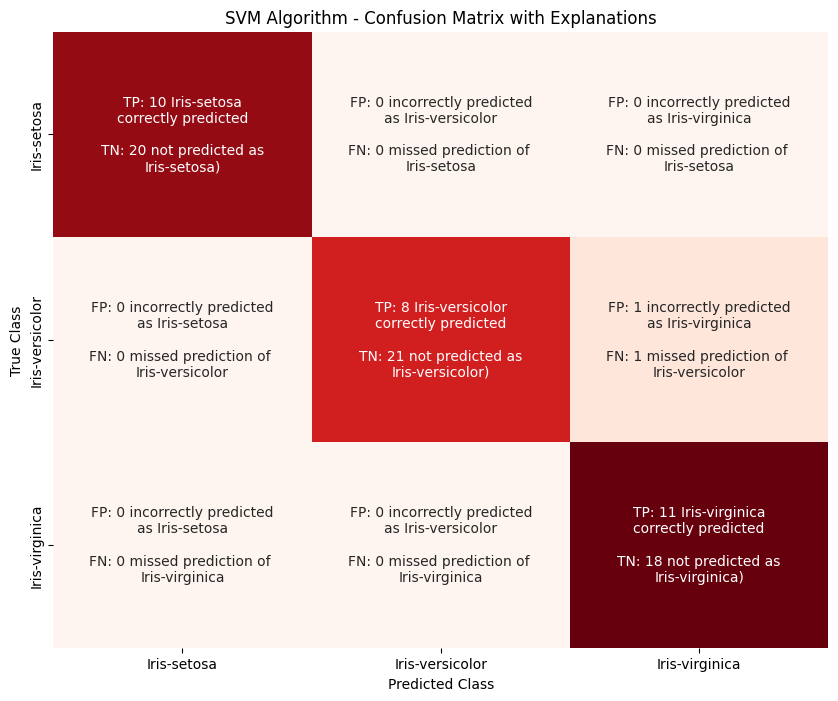

In [107]:
# Train SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)

# Evaluation
evaluate_model("SVM", y_test, svm_pred, svm_model)

## Cross-Validation and Summary
Performing cross-validation on all models and comparing the results.

In [108]:
# Cross-validation scores
rf1_cv = cross_val_score(rf_model_1, X_train, y_train, cv=5).mean()
rf2_cv = cross_val_score(rf_model_2, X_train, y_train, cv=5).mean()
knn_cv = cross_val_score(knn_model, X_train_scaled, y_train, cv=5).mean()
svm_cv = cross_val_score(svm_model, X_train_scaled, y_train, cv=5).mean()

# Print results
print(
    f"Cross-Validation - \nRandom Forest-1: {rf1_cv:.2f}\n"
    f"Random Forest-2: {rf2_cv:.2f}\n"
    f"KNN: {knn_cv:.2f}\nSVM: {svm_cv:.2f}"
)

Cross-Validation - 
Random Forest-1: 0.94
Random Forest-2: 0.95
KNN: 0.93
SVM: 0.95


#### Why Random Forest Despite Lower Cross-Validation
Random Forest may have a slightly lower/higher cross-validation score because it’s more complex than KNN or SVM, which can lead to overfitting when data is limited. However, Random Forest remains valuable for its interpretability, feature importance insights, and resilience against variance, making it a strong choice.